# MC-Dropout Classification

## Imports

In [29]:
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MCDropoutClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_two_moons_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_everything(0)

Global seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [4]:
dm = TwoMoonsDataModule(batch_size=128)
dm.setup()

X_train, y_train, X_test, y_test, test_grid_points = dm.X_train, dm.y_train, dm.X_test, dm.y_test, dm.test_grid_points

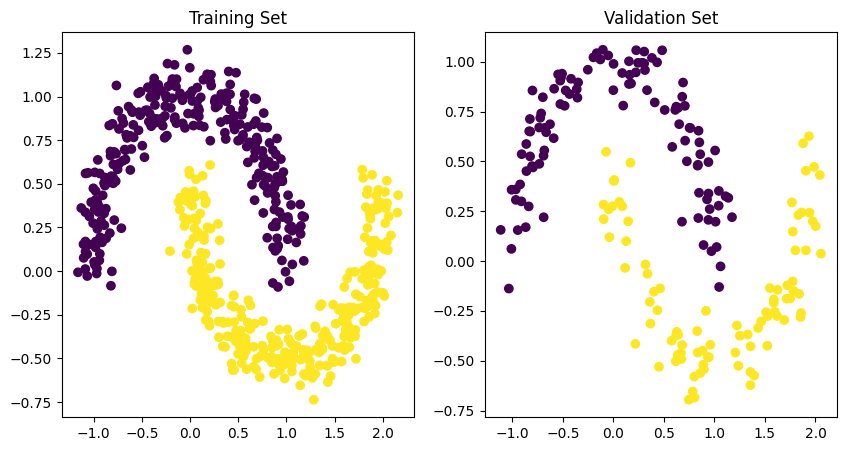

In [5]:
plot_two_moons_data(X_train, y_train, X_test, y_test)

## Model

In [6]:
network = MLP(
    n_inputs=2,
    n_hidden=[50, 50, 50],
    n_outputs=2,
    dropout_p=0.2,
    activation_fn=nn.ReLU(),
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [7]:
mc_dropout_module = MCDropoutClassification(
    model=network,
    optimizer=partial(Adam, lr=1e-2),
    loss_fn=nn.CrossEntropyLoss(),
    num_mc_samples=25,
)

## Trainer

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(mc_dropout_module, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.4 K 
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/t

## Training Metrics

Index(['train_loss', 'epoch', 'step', 'val_loss', 'valAcc', 'valF1Score',
       'trainAcc', 'trainF1Score'],
      dtype='object')


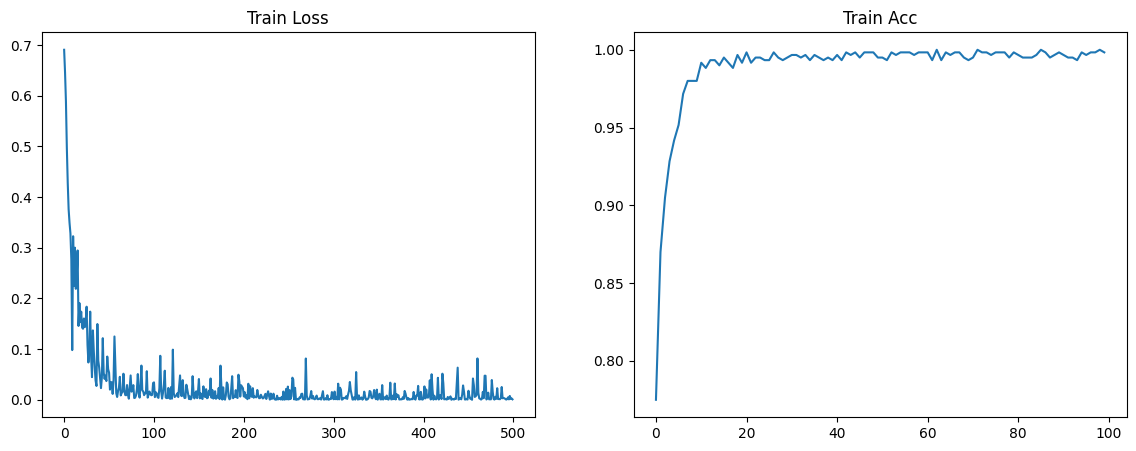

In [10]:
fig = plot_training_metrics(my_temp_dir, "Acc")

## Prediction

In [11]:
# save predictions
trainer.test(mc_dropout_module, dm.test_dataloader())

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          valAcc           │            1.0            │
│        valF1Score         │            1.0            │
└───────────────────────────┴───────────────────────────┘

[{'valAcc': 1.0, 'valF1Score': 1.0}]

In [12]:
preds = mc_dropout_module.predict_step(test_grid_points)

In [26]:
preds["pred"].shape, preds["pred_uct"].shape, X_test.shape, y_test.shape

(torch.Size([10000, 2]),
 torch.Size([10000]),
 torch.Size([200, 2]),
 torch.Size([200]))

## Evaluate Predictions

torch.Size([100, 100])
torch.Size([100, 100])


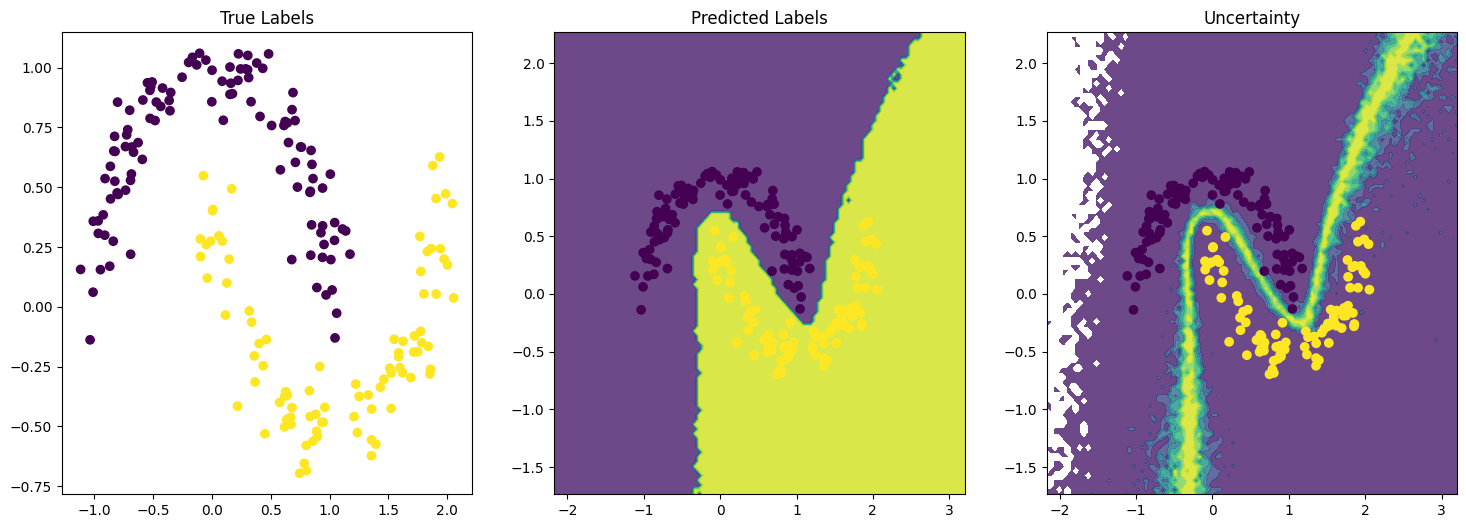

In [30]:
fig = plot_predictions_classification(X_test, y_test, preds["pred"].argmax(-1), preds["pred_uct"], test_grid_points)